# Classification of Dialects using Spectral Moments and Formants

In [1]:
#Prerequisites
# Charalambos Themistocleous
# In this work I study the three main variants of PPA. So, I have excluded the non PPA variant. 
# Clean Memory before rerunning
for name in dir():
    if not name.startswith('_'): del globals()[name]
#dir()

# Experiment 2

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals


# libraries for dataset preparation, feature engineering, model training 
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve, classification_report

from keras import layers, models, optimizers
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras.layers import Dense, Dropout, GaussianNoise, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from scipy import interp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy, textblob, string, os

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def evaluate_from_history(history_model):
    """Charalambos Themistocleous 2018"""
    k =1
    accuracy = []
    sd_accuracy = []
    loss = []
    valid_accuracy = []
    sd_valid_accuracy = []
    valid_loss = []
    for i in history_model:
        model_hist = i
        #print("Epoch: {}\nAccuracy: {}, Loss: {}, \nValidation Accuracy: {} Validation Loss {}".format(accuracy, loss, valid_accuracy,valid_loss))
        accuracy.append(np.mean(model_hist.history['acc']))
        sd_accuracy.append(np.std(model_hist.history['acc']))
        loss.append(np.mean(model_hist.history['loss']))
        valid_accuracy.append(np.mean(model_hist.history['val_acc']))
        valid_accuracy.append(np.mean(model_hist.history['val_acc']))
        sd_valid_accuracy.append(np.std(model_hist.history['val_acc']))
        valid_loss.append(np.mean(model_hist.history['val_loss']))
        k = k+1 
    print("===========================================================================")
    print("\nTotal Results:\
    \nFinal Accuracy: {}\
    \nSD Accuracy: {}\
    \nFinal Loss: {}\
    \nFinal Validation Accuracy: {}\
    \nSD Validation Accuracy: {}\
    \nFinal Validation Loss: {}".format(np.mean(accuracy),
                                         np.std(accuracy),
                                         np.mean(loss),
                                         np.mean(valid_accuracy),
                                         np.std(valid_accuracy),
                                         np.mean(valid_loss)))


In [4]:
# to make this notebook's output stable across runs


# To plot pretty figures
%matplotlib inline
plt.rcParams['legend.fontsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = 10, 10

# Where to save the figures
PROJECT_ROOT_DIR = "."
TITLE_ID = "speech_features"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "figures", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [5]:
# Import data
import pandas as pd
SEED = 2000
np.random.seed(SEED)

pd.options.display.max_columns = None

In [6]:
# Import Data

In [7]:
data = pd.read_csv("n.csv")

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (113) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data = data.loc[data["Segment"].isin(["l","n","r", "m"])]
data.head()
#data = data.drop(["phone"], axis=1)

,Unnamed: 0,AA,file,label,Duration,F1.5,F2.5,F3.5,F4.5,F5.5,F1.10,F2.10,F3.10,F4.10,F5.10,F1.15,F2.15,F3.15,F4.15,F5.15,F1.20,F2.20,F3.20,F4.20,F5.20,F1.25,F2.25,F3.25,F4.25,F5.25,F1.30,F2.30,F3.30,F4.30,F5.30,F1.35,F2.35,F3.35,F4.35,F5.35,F1.40,F2.40,F3.40,F4.40,F5.40,F1.45,F2.45,F3.45,F4.45,F5.45,F1.50,F2.50,F3.50,F4.50,F5.50,F1.55,F2.55,F3.55,F4.55,F5.55,F1.60,F2.60,F3.60,F4.60,F5.60,F1.65,F2.65,F3.65,F4.65,F5.65,F1.70,F2.70,F3.70,F4.70,F5.70,F1.75,F2.75,F3.75,F4.75,F5.75,F1.80,F2.80,F3.80,F4.80,F5.80,F1.85,F2.85,F3.85,F4.85,F5.85,F1.90,F2.90,F3.90,F4.90,F5.90,F1.95,F2.95,F3.95,F4.95,F5.95,X2,aa,file.1,label.1,duration,f0_min,f0_mean,f0_max,int_min,int_mean,int_max,F1,F2,F3,Keyword,Speaker,Variety,Segment,Selection,Position,Stress,VowelSelection
0,1,1,lasa1_02_03_2014_alexandra_1_217,l,0.103076,462.956029,1621.701238,2974.761385,3094.830543,3094.830543,495.715934,1738.396194,3105.424932,4102.091162,NaN,476.946532,1721.993020,3018.291800,3430.513395,4274.470088,464.298465,1711.277666,2859.388479,2975.642535,4274.028007,465.888169,1713.791759,2533.553015,3024.815894,4272.557677,465.792518,1690.790895,2404.457809,3071.747201,4276.784377,462.705218,1622.498840,2624.593068,3114.698680,4291.123784,461.201834,1592.197296,2805.323105,3138.116601,4290.963741,461.885488,1614.352209,2931.643285,3134.563016,4270.783176,462.956029,1621.701238,2974.761385,3094.830543,4261.099665,464.446184,1612.992047,2927.639871,3015.859040,4262.801087,465.793598,1602.131260,2925.502377,3089.826436,4224.420282,467.019120,1589.433152,2961.778285,3294.393620,4151.811887,467.978628,1570.319098,2969.607441,3412.190963,4120.996798,468.760110,1546.911232,2958.398870,3471.918384,4118.151498,469.257497,1524.327394,2928.732197,3490.929028,4181.240471,469.607721,1502.170414,2889.503994,3488.847867,4278.484230,480.119459,1502.393391,2916.670175,3518.438732,4181.025409,494.613594,1511.387292,2969.856967,3518.438732,4181.025409,7686,1,lasa1_02_03_2014_alexandra_1_217,l,103,153.0,157.0,158.0,52,54,54,488,1625,2861,lasa1,alexandra,SMG,l,l,Initial,Unstressed,FAIL
4,5,5,lasa1_02_03_2014_alexandra_1_40,l,0.120918,427.852869,1637.478983,3054.324594,3866.841883,3866.841883,466.235957,1708.842706,2787.986654,3496.769004,4233.974862,417.883289,1614.438037,2655.474679,3081.970766,4254.335211,419.587956,1467.360745,2792.753533,3082.082421,4303.155164,423.308499,1568.876704,2952.413799,3645.658050,4314.723531,426.907335,1725.571394,3100.521788,4251.231392,NaN,424.395910,1702.315190,3097.430207,3770.092615,4299.551898,423.932289,1686.859154,3091.191908,3711.089417,4299.551898,425.921323,1680.745382,3081.184784,4157.678096,NaN,427.852869,1637.478983,3054.324594,3866.841883,NaN,428.510430,1590.664010,3016.444402,3459.281084,4289.380423,421.858404,1576.813380,2938.912892,3437.406709,4286.702174,422.205991,1548.197452,2903.363860,3392.090635,4310.148274,429.752178,1504.396472,2910.990804,3322.666450,4360.461396,444.466312,1481.838442,2938.176676,3339.611474,4452.551261,459.659678,1472.347374,2962.360140,3447.431308,4534.141641,470.903181,1502.468016,2956.774790,3882.625612,NaN,515.801042,1558.149784,2974.837359,4225.616985,NaN,590.428065,1636.411416,3013.789728,4225.616985,NaN,7692,5,lasa1_02_03_2014_alexandra_1_40,l,121,181.0,206.0,223.0,53,55,57,465,1634,2998,lasa1,alexandra,SMG,l,l,Initial,Unstressed,FAIL
8,9,9,lasa1_02_03_2014_angeliki_205,l,0.077098,505.662297,1434.702965,2859.892959,3279.522116,3279.522116,475.838389,1692.049329,2957.239666,3513.631742,4510.469164,487.866658,1666.552160,2934.428764,3546.094373,4510.122349,497.011297,1653.942579,2916.275768,3554.068686,4502.490004,499.302237,1671.963725,2909.193506,3503.840100,4477.541690,501.593176,1689.984872,2902.111245,3453.611514,4452.593377,501.934050,1657.867181,2889.566193,3400.811307,4450.175571,501.447234,1604.468492,2874.702506,3346.919598,4457.320645,501.465827,1544.936348,2861.291900,3296.961707,4463.020682,505.662297,1434.702965,2859.892959,3279.522116,4456.775539,509.858768,1324.469582,2858.494018,3262.082524,445

In [9]:
data.shape

(2543, 122)

In [10]:
smdata = pd.read_csv("spectralmoments.csv")

In [11]:
smdata.head()

,Unnamed: 0,X.1,X,AA,file,Segment,duration,intensity,cog,sdev,skew,kurt,Speaker,keyword,Variety,Stress
0,1,1,1,1,λάσα_exp2_aliki_kontou_1_mono_24,l,119.890596,43.385975,611.950268,629.108530,17.201298,396.427305,alikikontou,lasa,CG,Stressed
1,2,2,2,2,λάσα_exp2_aliki_kontou_2_mono_176,l,90.639835,53.413668,811.575781,758.028018,9.377192,139.275050,alikikontou,lasa,CG,Stressed
2,3,3,3,3,λάσα_exp2_andri_athanasiou_mono_218,l,119.896107,55.893148,1015.390699,880.517781,3.306742,19.270265,andriathanasiou,lasa,CG,Stressed
3,4,4,4,4,λάσα_exp2_andri_athanasiou_mono_25,l,119.167025,56.423559,1045.030648,1020.526720,5.588071,54.850927,andriathanasiou,lasa,CG,Stressed
4,5,5,5,5,λάσα_exp2_andri_chatra_mono_222,l,58.836384,50.861743,953.242924,1015.228268,9.506986,136.939518,andrichatra,lasa,CG,Stressed


In [12]:
result =  pd.merge(data, smdata,  how='right', on=['file'])
# it seems that two rows are missing from the smdata and because we do not want to have missing information we exclude these by saying that get only the columsn that exist in smdata by selecting how is "left".



In [13]:
result.shape

(2541, 137)

In [14]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2541 entries, 0 to 2540
Columns: 137 entries, Unnamed: 0_x to Stress_y
dtypes: float64(105), int64(14), object(18)
memory usage: 2.7+ MB


In [15]:
for i in result.columns:
    print(i)

Unnamed: 0_x
AA_x
file
label
Duration
F1.5
F2.5
F3.5
F4.5
F5.5
F1.10
F2.10
F3.10
F4.10
F5.10
F1.15
F2.15
F3.15
F4.15
F5.15
F1.20
F2.20
F3.20
F4.20
F5.20
F1.25
F2.25
F3.25
F4.25
F5.25
F1.30
F2.30
F3.30
F4.30
F5.30
F1.35
F2.35
F3.35
F4.35
F5.35
F1.40
F2.40
F3.40
F4.40
F5.40
F1.45
F2.45
F3.45
F4.45
F5.45
F1.50
F2.50
F3.50
F4.50
F5.50
F1.55
F2.55
F3.55
F4.55
F5.55
F1.60
F2.60
F3.60
F4.60
F5.60
F1.65
F2.65
F3.65
F4.65
F5.65
F1.70
F2.70
F3.70
F4.70
F5.70
F1.75
F2.75
F3.75
F4.75
F5.75
F1.80
F2.80
F3.80
F4.80
F5.80
F1.85
F2.85
F3.85
F4.85
F5.85
F1.90
F2.90
F3.90
F4.90
F5.90
F1.95
F2.95
F3.95
F4.95
F5.95
X2
aa
file.1
label.1
duration_x
f0_min
f0_mean
f0_max
int_min
int_mean
int_max
F1
F2
F3
Keyword
Speaker_x
Variety_x
Segment_x
Selection
Position
Stress_x
VowelSelection
Unnamed: 0_y
X.1
X
AA_y
Segment_y
duration_y
intensity
cog
sdev
skew
kurt
Speaker_y
keyword
Variety_y
Stress_y


In [16]:
columns =  ['Speaker_x','label','Variety_x','duration_x', 'f0_mean', 'f0_min', 'f0_max',
            'F1.25', 'F1.50', 'F1.75', 'F2.25', 'F2.50', 
            'F2.75', 'F3.25', 'F3.50', 'F3.75', 'F4.25', 
            'F4.50', 'F4.75', 'F5.25', 'F5.50', 'F5.75', 'F1', 'F2', 'F3', 
            'intensity', 'cog', 'sdev', 'skew', 'kurt']
df = result[columns]

In [17]:
df.select_dtypes(include=['object']).copy()
set(df.label)

{'l', 'm', 'n', 'r'}

In [18]:
df.Variety_x.value_counts()

CG     1274
SMG    1267
Name: Variety_x, dtype: int64

In [19]:
cleanup_nums = {'Speaker_x': {'alexandra': 1,
                            'alikikontou': 2, 'andriathanasiou': 3, 'andrichatra': 4, 'andrichristophi': 5,
                            'andrilouka': 6, 'angelandriasavva': 7,
                            'angeliki': 8, 'annasp': 9, 'annaz': 10, 'anthoulakoupepia': 11, 'antonia': 12,
                            'aristodemouandri': 13,
                            'christianachristodoulou': 14, 'eleninikolaou': 15, 'elina': 16, 'emilialanitou': 17,
                            'frosw': 18,
                            'georgiaioannou': 19, 'giannachatziiosif': 20, 'giannaok': 21, 'govari': 22,
                            'irinichatzigiannakou': 23,
                            'iris': 25, 'isidora': 26, 'katerina': 27, 'katerinalar': 28, 'katerinamiltiadous': 29,
                            'mariaantioniou': 30,
                            'mariamavronikola': 31, 'maro': 32, 'rania': 33, 'stellaevangelou': 34, 'swtiria': 35,
                            'theodouloumaria': 36, 'vangelio': 37, 'vasia': 38, 'vasw': 39, 'venetia': 40,
                            'zoiparaskeva': 41},
                'Variety_x': {'CG': 0, 'SMG': 1},
                'label': {'l': 1, 'm': 2, 'n': 3, 'r': 0}
                }

In [20]:
df.replace(cleanup_nums, inplace=True)

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [21]:
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0) 
dfim=imp.fit_transform(df)
df = pd.DataFrame(dfim, columns=columns)

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [22]:
# Select a test set
test= df[df["Speaker_x"].isin(["1","8","16","26","5","6","17","34"])] 
# Select a training set
train= df[~df["Speaker_x"].isin(["1","8","16","26","5","6","17","34"])] #Female 1
print(df.shape, train.shape,  test.shape)

(2541, 30) (2033, 30) (508, 30)


In [23]:
a=np.log(df)
a = a.drop(["Speaker_x"], axis=1)
corr_matrix=a.corr() 
corr_matrix['Variety_x'].sort_values(ascending=False)

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


label        NaN
Variety_x    NaN
duration_x   NaN
f0_mean      NaN
f0_min       NaN
f0_max       NaN
F1.25        NaN
F1.50        NaN
F1.75        NaN
F2.25        NaN
F2.50        NaN
F2.75        NaN
F3.25        NaN
F3.50        NaN
F3.75        NaN
F4.25        NaN
F4.50        NaN
F4.75        NaN
F5.25        NaN
F5.50        NaN
F5.75        NaN
F1           NaN
F2           NaN
F3           NaN
intensity    NaN
cog          NaN
sdev         NaN
skew         NaN
kurt         NaN
Name: Variety_x, dtype: float64

In [24]:
# define 10-fold cross validation test harness
# remove speaker column
X_train = train.drop(["Speaker_x"], axis=1)
X_test  = test.drop(["Speaker_x"], axis=1)
y_train = X_train.Variety_x
y_test = X_test.Variety_x
X_train= X_train.drop(["Variety_x"], axis=1)
X_test = X_test.drop(["Variety_x"], axis=1)

In [25]:
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve
from scipy import interp
from keras.optimizers import SGD

cRF_tprs = []
cRF_aucs = []
cSVM_tprs = []
cSVM_aucs = []
cDT_tprs = []
cDT_aucs = []
cSNN_tprs = []
cSNN_aucs = []


mean_fpr = np.linspace(0, 1, 100)
cRF_resultsA = []
cSVM_resultsA = []
cDT_resultsA = []
cSNN_resultsA = []

cRF_resultsB = []
cSVM_resultsB = []
cDT_resultsB = []
cSNN_resultsB = []

history = []
i = 0

epochs = 800
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)


# Define the neural network here
snn = Sequential()
snn.add(Dense(110, input_dim=28, activation='relu'))
snn.add(Dense(110, activation='relu'))
snn.add(Dense(110, activation='relu'))
snn.add(Dense(110, activation='relu'))
snn.add(Dense(110, activation='relu'))
snn.add(Dense(1, kernel_initializer='random_normal', activation='sigmoid'))
snn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

#logo.get_n_splits(groups=groups) # 'groups' is always required

scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
#
# Compile model
cRF = RandomForestClassifier(n_estimators=512, max_depth=None, min_samples_split=2, random_state=30).fit(X_train_transformed, y_train)
cSVM = svm.SVC(C=3, kernel="linear").fit(X_train_transformed, y_train)
cDT = DecisionTreeClassifier(random_state=452).fit(X_train_transformed, y_train)
cSNN = snn.fit(X_train_transformed, y_train, validation_data= (X_test_transformed, y_test), epochs=epochs, batch_size=35, verbose=True)
history.append(cSNN)
# Transform X_Test  

Train on 2033 samples, validate on 508 samples
Epoch 1/800
2033/2033 [==============================] - 0s 96us/step - loss: 0.6931 - acc: 0.4875 - val_loss: 0.6933 - val_acc: 0.4665
Epoch 2/800
2033/2033 [==============================] - 0s 57us/step - loss: 0.6930 - acc: 0.5165 - val_loss: 0.6931 - val_acc: 0.4961
Epoch 3/800
2033/2033 [==============================] - 0s 66us/step - loss: 0.6928 - acc: 0.5342 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 4/800
2033/2033 [==============================] - 0s 57us/step - loss: 0.6927 - acc: 0.5017 - val_loss: 0.6929 - val_acc: 0.5276
Epoch 5/800
2033/2033 [==============================] - 0s 59us/step - loss: 0.6926 - acc: 0.5258 - val_loss: 0.6928 - val_acc: 0.5394
Epoch 6/800
2033/2033 [==============================] - 0s 51us/step - loss: 0.6925 - acc: 0.5706 - val_loss: 0.6927 - val_acc: 0.5256
Epoch 7/800
2033/2033 [==============================] - 0s 51us/step - loss: 0.6924 - acc: 0.5701 - val_loss: 0.6926 - val_acc: 0.5394
E

2033/2033 [==============================] - 0s 82us/step - loss: 0.5892 - acc: 0.7068 - val_loss: 0.5893 - val_acc: 0.6850
Epoch 61/800
2033/2033 [==============================] - 0s 76us/step - loss: 0.5865 - acc: 0.7063 - val_loss: 0.6223 - val_acc: 0.6457
Epoch 62/800
2033/2033 [==============================] - 0s 66us/step - loss: 0.5781 - acc: 0.7034 - val_loss: 0.5892 - val_acc: 0.6831
Epoch 63/800
2033/2033 [==============================] - 0s 59us/step - loss: 0.5777 - acc: 0.6990 - val_loss: 0.5989 - val_acc: 0.6693
Epoch 64/800
2033/2033 [==============================] - 0s 58us/step - loss: 0.5714 - acc: 0.7108 - val_loss: 0.5923 - val_acc: 0.6673
Epoch 65/800
2033/2033 [==============================] - 0s 58us/step - loss: 0.5679 - acc: 0.7157 - val_loss: 0.6693 - val_acc: 0.5827
Epoch 66/800
2033/2033 [==============================] - 0s 58us/step - loss: 0.5657 - acc: 0.7241 - val_loss: 0.6735 - val_acc: 0.6122
Epoch 67/800
2033/2033 [==============================

2033/2033 [==============================] - 0s 58us/step - loss: 0.4853 - acc: 0.7634 - val_loss: 0.7768 - val_acc: 0.5630
Epoch 120/800
2033/2033 [==============================] - 0s 56us/step - loss: 0.4773 - acc: 0.7634 - val_loss: 0.9982 - val_acc: 0.5512
Epoch 121/800
2033/2033 [==============================] - 0s 68us/step - loss: 0.4808 - acc: 0.7570 - val_loss: 0.5059 - val_acc: 0.7638
Epoch 122/800
2033/2033 [==============================] - 0s 61us/step - loss: 0.4559 - acc: 0.7816 - val_loss: 0.7782 - val_acc: 0.6220
Epoch 123/800
2033/2033 [==============================] - 0s 61us/step - loss: 0.4702 - acc: 0.7629 - val_loss: 0.5182 - val_acc: 0.7362
Epoch 124/800
2033/2033 [==============================] - 0s 49us/step - loss: 0.4627 - acc: 0.7777 - val_loss: 0.5045 - val_acc: 0.7461
Epoch 125/800
2033/2033 [==============================] - 0s 51us/step - loss: 0.4688 - acc: 0.7718 - val_loss: 0.5110 - val_acc: 0.7362
Epoch 126/800
2033/2033 [=======================

2033/2033 [==============================] - 0s 54us/step - loss: 0.4096 - acc: 0.8052 - val_loss: 1.2785 - val_acc: 0.5413
Epoch 179/800
2033/2033 [==============================] - 0s 59us/step - loss: 0.4242 - acc: 0.8018 - val_loss: 1.3182 - val_acc: 0.5217
Epoch 180/800
2033/2033 [==============================] - 0s 68us/step - loss: 0.4270 - acc: 0.7959 - val_loss: 0.9760 - val_acc: 0.6102
Epoch 181/800
2033/2033 [==============================] - 0s 78us/step - loss: 0.4194 - acc: 0.7983 - val_loss: 0.7362 - val_acc: 0.6693
Epoch 182/800
2033/2033 [==============================] - 0s 81us/step - loss: 0.4100 - acc: 0.8121 - val_loss: 0.8481 - val_acc: 0.6181
Epoch 183/800
2033/2033 [==============================] - 0s 102us/step - loss: 0.4136 - acc: 0.8013 - val_loss: 1.2135 - val_acc: 0.5217
Epoch 184/800
2033/2033 [==============================] - 0s 98us/step - loss: 0.4215 - acc: 0.8028 - val_loss: 1.6224 - val_acc: 0.5217
Epoch 185/800
2033/2033 [======================

2033/2033 [==============================] - 0s 59us/step - loss: 0.3568 - acc: 0.8382 - val_loss: 0.5866 - val_acc: 0.7224
Epoch 238/800
2033/2033 [==============================] - 0s 62us/step - loss: 0.3477 - acc: 0.8470 - val_loss: 0.6050 - val_acc: 0.7362
Epoch 239/800
2033/2033 [==============================] - 0s 71us/step - loss: 0.3500 - acc: 0.8436 - val_loss: 0.5918 - val_acc: 0.6969
Epoch 240/800
2033/2033 [==============================] - 0s 63us/step - loss: 0.3584 - acc: 0.8244 - val_loss: 0.6163 - val_acc: 0.6988
Epoch 241/800
2033/2033 [==============================] - 0s 62us/step - loss: 0.3659 - acc: 0.8313 - val_loss: 0.5239 - val_acc: 0.7461
Epoch 242/800
2033/2033 [==============================] - 0s 101us/step - loss: 0.3588 - acc: 0.8465 - val_loss: 0.5696 - val_acc: 0.7323
Epoch 243/800
2033/2033 [==============================] - 0s 92us/step - loss: 0.3465 - acc: 0.8465 - val_loss: 0.6499 - val_acc: 0.7146
Epoch 244/800
2033/2033 [======================

2033/2033 [==============================] - 0s 101us/step - loss: 0.3151 - acc: 0.8539 - val_loss: 1.0577 - val_acc: 0.6024
Epoch 297/800
2033/2033 [==============================] - 0s 103us/step - loss: 0.3230 - acc: 0.8569 - val_loss: 0.9940 - val_acc: 0.6102
Epoch 298/800
2033/2033 [==============================] - 0s 119us/step - loss: 0.3242 - acc: 0.8529 - val_loss: 0.6347 - val_acc: 0.7362
Epoch 299/800
2033/2033 [==============================] - 0s 103us/step - loss: 0.2922 - acc: 0.8780 - val_loss: 0.6232 - val_acc: 0.7047
Epoch 300/800
2033/2033 [==============================] - 0s 61us/step - loss: 0.2988 - acc: 0.8637 - val_loss: 0.6556 - val_acc: 0.7362
Epoch 301/800
2033/2033 [==============================] - 0s 57us/step - loss: 0.3210 - acc: 0.8554 - val_loss: 0.7101 - val_acc: 0.6555
Epoch 302/800
2033/2033 [==============================] - 0s 58us/step - loss: 0.2886 - acc: 0.8760 - val_loss: 0.6925 - val_acc: 0.7205
Epoch 303/800
2033/2033 [===================

2033/2033 [==============================] - 0s 64us/step - loss: 0.2895 - acc: 0.8765 - val_loss: 0.7511 - val_acc: 0.7126
Epoch 356/800
2033/2033 [==============================] - 0s 64us/step - loss: 0.2604 - acc: 0.8741 - val_loss: 0.6458 - val_acc: 0.7126
Epoch 357/800
2033/2033 [==============================] - 0s 65us/step - loss: 0.2580 - acc: 0.8869 - val_loss: 0.6416 - val_acc: 0.7067
Epoch 358/800
2033/2033 [==============================] - 0s 66us/step - loss: 0.2502 - acc: 0.8898 - val_loss: 0.6322 - val_acc: 0.7382
Epoch 359/800
2033/2033 [==============================] - 0s 60us/step - loss: 0.2661 - acc: 0.8795 - val_loss: 1.7403 - val_acc: 0.5709
Epoch 360/800
2033/2033 [==============================] - 0s 68us/step - loss: 0.2793 - acc: 0.8864 - val_loss: 0.7145 - val_acc: 0.6929
Epoch 361/800
2033/2033 [==============================] - 0s 92us/step - loss: 0.2579 - acc: 0.8824 - val_loss: 0.6683 - val_acc: 0.7224
Epoch 362/800
2033/2033 [=======================

2033/2033 [==============================] - 0s 81us/step - loss: 0.2433 - acc: 0.8908 - val_loss: 0.7065 - val_acc: 0.7402
Epoch 415/800
2033/2033 [==============================] - 0s 117us/step - loss: 0.2217 - acc: 0.9036 - val_loss: 0.7430 - val_acc: 0.7047
Epoch 416/800
2033/2033 [==============================] - 0s 93us/step - loss: 0.2322 - acc: 0.9026 - val_loss: 0.7574 - val_acc: 0.7067
Epoch 417/800
2033/2033 [==============================] - 0s 77us/step - loss: 0.2031 - acc: 0.9203 - val_loss: 0.8784 - val_acc: 0.6516
Epoch 418/800
2033/2033 [==============================] - 0s 80us/step - loss: 0.2118 - acc: 0.9105 - val_loss: 1.7233 - val_acc: 0.6142
Epoch 419/800
2033/2033 [==============================] - 0s 75us/step - loss: 0.2654 - acc: 0.8893 - val_loss: 0.7984 - val_acc: 0.6673
Epoch 420/800
2033/2033 [==============================] - 0s 68us/step - loss: 0.2036 - acc: 0.9129 - val_loss: 0.8925 - val_acc: 0.6772
Epoch 421/800
2033/2033 [======================

2033/2033 [==============================] - 0s 56us/step - loss: 0.1794 - acc: 0.9247 - val_loss: 0.7549 - val_acc: 0.7264
Epoch 474/800
2033/2033 [==============================] - 0s 56us/step - loss: 0.1661 - acc: 0.9302 - val_loss: 0.8537 - val_acc: 0.7028
Epoch 475/800
2033/2033 [==============================] - 0s 59us/step - loss: 0.1747 - acc: 0.9238 - val_loss: 0.7365 - val_acc: 0.7283
Epoch 476/800
2033/2033 [==============================] - 0s 59us/step - loss: 0.1803 - acc: 0.9208 - val_loss: 1.1138 - val_acc: 0.6122
Epoch 477/800
2033/2033 [==============================] - 0s 79us/step - loss: 0.1916 - acc: 0.9154 - val_loss: 0.7910 - val_acc: 0.7146
Epoch 478/800
2033/2033 [==============================] - 0s 75us/step - loss: 0.1859 - acc: 0.9203 - val_loss: 1.3337 - val_acc: 0.5827
Epoch 479/800
2033/2033 [==============================] - 0s 73us/step - loss: 0.2066 - acc: 0.9120 - val_loss: 1.0356 - val_acc: 0.6516
Epoch 480/800
2033/2033 [=======================

2033/2033 [==============================] - 0s 62us/step - loss: 0.1683 - acc: 0.9380 - val_loss: 0.8548 - val_acc: 0.6969
Epoch 533/800
2033/2033 [==============================] - 0s 68us/step - loss: 0.1764 - acc: 0.9198 - val_loss: 0.7966 - val_acc: 0.7283
Epoch 534/800
2033/2033 [==============================] - 0s 67us/step - loss: 0.1490 - acc: 0.9390 - val_loss: 1.0720 - val_acc: 0.7008
Epoch 535/800
2033/2033 [==============================] - 0s 61us/step - loss: 0.1661 - acc: 0.9302 - val_loss: 0.9379 - val_acc: 0.7126
Epoch 536/800
2033/2033 [==============================] - 0s 66us/step - loss: 0.1349 - acc: 0.9459 - val_loss: 0.8755 - val_acc: 0.7067
Epoch 537/800
2033/2033 [==============================] - 0s 63us/step - loss: 0.1329 - acc: 0.9484 - val_loss: 1.2060 - val_acc: 0.6398
Epoch 538/800
2033/2033 [==============================] - 0s 62us/step - loss: 0.1486 - acc: 0.9400 - val_loss: 1.0737 - val_acc: 0.6457
Epoch 539/800
2033/2033 [=======================

2033/2033 [==============================] - 0s 61us/step - loss: 0.1279 - acc: 0.9523 - val_loss: 1.6768 - val_acc: 0.6496
Epoch 592/800
2033/2033 [==============================] - 0s 88us/step - loss: 0.1258 - acc: 0.9498 - val_loss: 0.9986 - val_acc: 0.6969
Epoch 593/800
2033/2033 [==============================] - 0s 74us/step - loss: 0.0967 - acc: 0.9626 - val_loss: 1.2423 - val_acc: 0.6752
Epoch 594/800
2033/2033 [==============================] - 0s 64us/step - loss: 0.1568 - acc: 0.9405 - val_loss: 0.9236 - val_acc: 0.7047
Epoch 595/800
2033/2033 [==============================] - 0s 62us/step - loss: 0.1166 - acc: 0.9508 - val_loss: 0.9619 - val_acc: 0.6969
Epoch 596/800
2033/2033 [==============================] - 0s 61us/step - loss: 0.1304 - acc: 0.9439 - val_loss: 0.9417 - val_acc: 0.7146
Epoch 597/800
2033/2033 [==============================] - 0s 56us/step - loss: 0.1087 - acc: 0.9611 - val_loss: 1.7062 - val_acc: 0.6280
Epoch 598/800
2033/2033 [=======================

2033/2033 [==============================] - 0s 60us/step - loss: 0.0970 - acc: 0.9621 - val_loss: 1.0786 - val_acc: 0.6988
Epoch 651/800
2033/2033 [==============================] - 0s 56us/step - loss: 0.1114 - acc: 0.9557 - val_loss: 1.3494 - val_acc: 0.6791
Epoch 652/800
2033/2033 [==============================] - 0s 71us/step - loss: 0.1133 - acc: 0.9562 - val_loss: 0.8970 - val_acc: 0.7323
Epoch 653/800
2033/2033 [==============================] - 0s 62us/step - loss: 0.0788 - acc: 0.9729 - val_loss: 1.3629 - val_acc: 0.6693
Epoch 654/800
2033/2033 [==============================] - 0s 62us/step - loss: 0.1489 - acc: 0.9429 - val_loss: 0.9595 - val_acc: 0.7185
Epoch 655/800
2033/2033 [==============================] - 0s 51us/step - loss: 0.0822 - acc: 0.9710 - val_loss: 1.0652 - val_acc: 0.7106
Epoch 656/800
2033/2033 [==============================] - 0s 61us/step - loss: 0.1030 - acc: 0.9562 - val_loss: 0.9547 - val_acc: 0.7008
Epoch 657/800
2033/2033 [=======================

2033/2033 [==============================] - 0s 59us/step - loss: 0.0397 - acc: 0.9872 - val_loss: 1.1302 - val_acc: 0.7244
Epoch 710/800
2033/2033 [==============================] - 0s 52us/step - loss: 0.0386 - acc: 0.9887 - val_loss: 1.2626 - val_acc: 0.7087
Epoch 711/800
2033/2033 [==============================] - 0s 51us/step - loss: 0.0505 - acc: 0.9838 - val_loss: 1.1858 - val_acc: 0.7146
Epoch 712/800
2033/2033 [==============================] - 0s 51us/step - loss: 0.0549 - acc: 0.9833 - val_loss: 1.8538 - val_acc: 0.6280
Epoch 713/800
2033/2033 [==============================] - 0s 54us/step - loss: 0.0516 - acc: 0.9823 - val_loss: 1.1136 - val_acc: 0.7126
Epoch 714/800
2033/2033 [==============================] - 0s 56us/step - loss: 0.0368 - acc: 0.9902 - val_loss: 1.1415 - val_acc: 0.7283
Epoch 715/800
2033/2033 [==============================] - 0s 53us/step - loss: 0.0595 - acc: 0.9788 - val_loss: 2.5585 - val_acc: 0.5866
Epoch 716/800
2033/2033 [=======================

2033/2033 [==============================] - 0s 64us/step - loss: 0.0175 - acc: 0.9980 - val_loss: 1.2341 - val_acc: 0.7303
Epoch 769/800
2033/2033 [==============================] - 0s 69us/step - loss: 0.0210 - acc: 0.9951 - val_loss: 1.2751 - val_acc: 0.7283
Epoch 770/800
2033/2033 [==============================] - 0s 64us/step - loss: 0.0208 - acc: 0.9966 - val_loss: 1.2276 - val_acc: 0.7244
Epoch 771/800
2033/2033 [==============================] - 0s 63us/step - loss: 0.0638 - acc: 0.9803 - val_loss: 1.1560 - val_acc: 0.7421
Epoch 772/800
2033/2033 [==============================] - 0s 69us/step - loss: 0.0764 - acc: 0.9715 - val_loss: 1.2892 - val_acc: 0.7205
Epoch 773/800
2033/2033 [==============================] - 0s 66us/step - loss: 0.0189 - acc: 0.9970 - val_loss: 1.2150 - val_acc: 0.7224
Epoch 774/800
2033/2033 [==============================] - 0s 65us/step - loss: 0.0243 - acc: 0.9941 - val_loss: 1.6001 - val_acc: 0.6516
Epoch 775/800
2033/2033 [=======================

In [26]:
# Evaluate classifiers
cRF_y_pred = cRF.predict(X_test_transformed)
cSVM_y_pred = cSVM.predict(X_test_transformed)
cDT_y_pred = cDT.predict(X_test_transformed)
cSNN_y_pred = snn.predict_classes(X_test_transformed)
#print(cSNN_y_pred)

# Corrects
cRF_n_correct = sum(cRF_y_pred == y_test)
cSVM_n_correct = sum(cSVM_y_pred == y_test)
cDT_n_correct = sum(cDT_y_pred == y_test)
cSNN_n_correct = sum(cSNN_y_pred == y_test.values)

#
cRF_accuracy1 = cRF_n_correct / len(cRF_y_pred)
cSVM_accuracy1 = cSVM_n_correct / len(cSVM_y_pred)
cDT_accuracy1 = cDT_n_correct / len(cDT_y_pred)
cSNN_accuracy1 = cSNN_n_correct / len(cSNN_y_pred)

#
cRF_accuracy2 = cRF.score(X_test_transformed, y_test)
print(f"RF: {cRF_accuracy2}")
cSVM_accuracy2 = cSVM.score(X_test_transformed, y_test)
print(f"SVM: {cSVM_accuracy2}")
cDT_accuracy2 = cDT.score(X_test_transformed, y_test)
print(f"DT: {cDT_accuracy2}")
cSNN_accuracy2 = snn.evaluate(X_test_transformed, y_test, verbose=1)     
print(f"SNN: {cSNN_accuracy2}")
#
cRF_resultsA.append(cRF_accuracy1)
cSVM_resultsA.append(cSVM_accuracy1)
cDT_resultsA.append(cDT_accuracy1)
cSNN_resultsA.append(cSNN_accuracy1)

#
cRF_resultsB.append(cRF_accuracy2)
cSVM_resultsB.append(cSVM_accuracy2)
cDT_resultsB.append(cDT_accuracy2)
cSNN_resultsB.append(cSNN_accuracy2)

# Compute ROC curve and area the curve RF
cRF_fpr, cRF_tpr, cRF_thresholds = roc_curve(y_test, cRF_y_pred)
cRF_tprs.append(interp(mean_fpr, cRF_fpr, cRF_tpr))
cRF_tprs[-1][0] = 0.0
cRF_roc_auc = auc(cRF_fpr, cRF_tpr)
cRF_aucs.append(cRF_roc_auc)

# Compute ROC curve and area the curve SVM
cSVM_fpr, cSVM_tpr, cSVM_thresholds = roc_curve(y_test, cSVM_y_pred)
cSVM_tprs.append(interp(mean_fpr, cSVM_fpr, cSVM_tpr))
cSVM_tprs[-1][0] = 0.0
cSVM_roc_auc = auc(cSVM_fpr, cSVM_tpr)
cSVM_aucs.append(cSVM_roc_auc)

# Compute ROC curve and area the curve
cDT_fpr, cDT_tpr, cDT_thresholds = roc_curve(y_test, cDT_y_pred)
cDT_tprs.append(interp(mean_fpr, cDT_fpr, cDT_tpr))
cDT_tprs[-1][0] = 0.0
cDT_roc_auc = auc(cDT_fpr, cDT_tpr)
cDT_aucs.append(cDT_roc_auc)

    # Compute ROC curve and area the curve RF
cSNN_fpr, cSNN_tpr, cSNN_thresholds = roc_curve(y_test, cSNN_y_pred)
cSNN_tprs.append(interp(mean_fpr, cSNN_fpr, cSNN_tpr))
cSNN_tprs[-1][0] = 0.0
cSNN_roc_auc = auc(cSNN_fpr, cSNN_tpr)
cSNN_aucs.append(cSNN_roc_auc)


# plt.plot(cRF_fpr, cRF_tpr, lw=3, alpha=0.3,
#          label='cRF_ROC fold %d (AUC = %0.2f)' % (i, cRF_roc_auc))
# plt.plot(cSVM_fpr, cSVM_tpr, lw=3, alpha=0.3,
#          label='cSVM_ROC fold %d (AUC = %0.2f)' % (i, cSVM_roc_auc))
# plt.plot(cDT_fpr, cDT_tpr, lw=3, alpha=0.3,
#          label='cDT_ROC fold %d (AUC = %0.2f)' % (i, cDT_roc_auc))

i += 1
print("RF Accuracy A: {}".format(cRF_resultsA))
print("RF Accuracy B: {}".format(cRF_resultsB))
print("RF ROC_AUC: {}".format(cRF_roc_auc))
print("RF Confusion Matrix: \n{}".format(confusion_matrix(y_test, cRF_y_pred)))
print(classification_report(y_test, cRF_y_pred, target_names=["Cypriot Greek", "Standard Modern Greek"]))

print("SVM Accuracy A: {}".format(cSVM_resultsA))
print("SVM Accuracy B: {}".format(cSVM_resultsB))
print("SVM ROC_AUC: {}".format(cSVM_roc_auc))
print("SVM Confusion Matrix: \n{}".format(confusion_matrix(y_test, cSVM_y_pred)))
print(classification_report(y_test, cSVM_y_pred, target_names=["Cypriot Greek", "Standard Modern Greek"]))


print("DT Accuracy A: {}".format(cDT_resultsA))
print("DT Accuracy B: {}".format(cDT_resultsB))
print("DT_ROC_AUC: {}".format(cDT_roc_auc))
print("DT Confusion Matrix: \n{}".format(confusion_matrix(y_test, cDT_y_pred)))
print(classification_report(y_test, cDT_y_pred, target_names=["Cypriot Greek", "Standard Modern Greek"]))

#print("sNN Accuracy A: {}".format(cSNN_resultsA))
print("sNN Accuracy B: {}".format(cSNN_resultsB))
print("sNN ROC_AUC: {}".format(cSNN_roc_auc))
print("sNN Confusion Matrix: \n{}".format(confusion_matrix(y_test, cSNN_y_pred)))
print(classification_report(y_test, cSNN_y_pred, target_names=["Cypriot Greek", "Standard Modern Greek"]))


RF: 0.7303149606299213
SVM: 0.7421259842519685
DT: 0.6318897637795275
508/508 [==============================] - 0s 36us/step
SNN: [1.3587980214066393, 0.7263779520519137]
RF Accuracy A: [0.7303149606299213]
RF Accuracy B: [0.7303149606299213]
RF ROC_AUC: 0.7303149606299213
RF Confusion Matrix: 
[[187  67]
 [ 70 184]]
                       precision    recall  f1-score   support

        Cypriot Greek       0.73      0.74      0.73       254
Standard Modern Greek       0.73      0.72      0.73       254

            micro avg       0.73      0.73      0.73       508
            macro avg       0.73      0.73      0.73       508
         weighted avg       0.73      0.73      0.73       508

SVM Accuracy A: [0.7421259842519685]
SVM Accuracy B: [0.7421259842519685]
SVM ROC_AUC: 0.7421259842519684
SVM Confusion Matrix: 
[[170  84]
 [ 47 207]]
                       precision    recall  f1-score   support

        Cypriot Greek       0.78      0.67      0.72       254
Standard Modern Gree

Mean AUC 0.7303027224772414
Mean AUC 0.7421045185751068
Mean AUC 0.6318745661032161
Mean AUC 0.7263581586418897
Saving figure fig


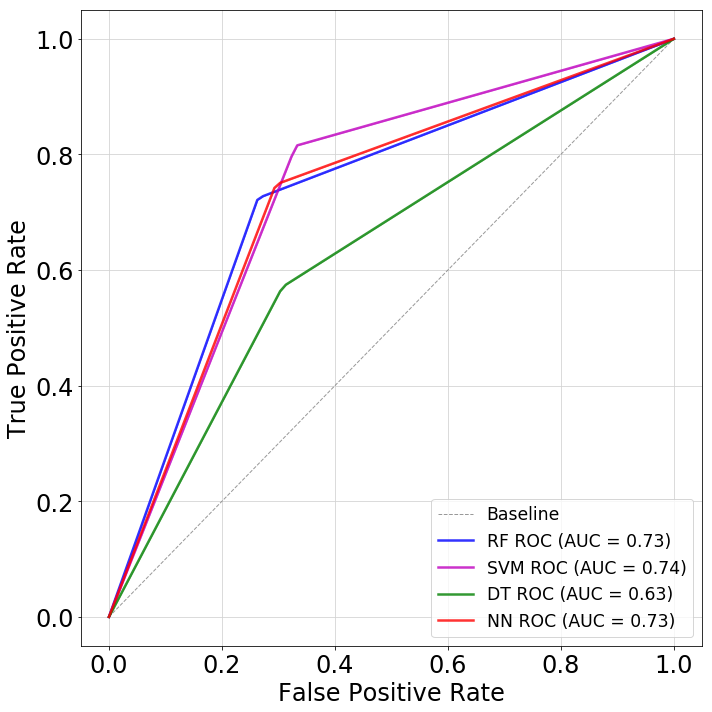

In [27]:
# PLOT THE BASELINE
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',
         label='Baseline', alpha=.8)

mean_cRF_tpr = np.mean(cRF_tprs, axis=0)
mean_cRF_tpr[-1] = 1.0
mean_cRF_auc = auc(mean_fpr, mean_cRF_tpr)
print("Mean AUC {}".format(mean_cRF_auc))
std_cRF_auc = np.std(cRF_aucs)

mean_cSVM_tpr = np.mean(cSVM_tprs, axis=0)
mean_cSVM_tpr[-1] = 1.0
mean_cSVM_auc = auc(mean_fpr, mean_cSVM_tpr)
print("Mean AUC {}".format(mean_cSVM_auc))
std_cSVM_auc = np.std(cSVM_aucs)

mean_cDT_tpr = np.mean(cDT_tprs, axis=0)
mean_cDT_tpr[-1] = 1.0
mean_cDT_auc = auc(mean_fpr, mean_cDT_tpr)
print("Mean AUC {}".format(mean_cDT_auc))
std_cDT_auc = np.std(cDT_aucs)

mean_cSNN_tpr = np.mean(cSNN_tprs, axis=0)
mean_cSNN_tpr[-1] = 1.0
mean_cSNN_auc = auc(mean_fpr, mean_cSNN_tpr)
print("Mean AUC {}".format(mean_cSNN_auc))
std_cSNN_auc = np.std(cSNN_aucs)

# PLOT the mean
plt.plot(mean_fpr, mean_cRF_tpr, color='b',
         label=r'RF ROC (AUC = %0.2f)' % (mean_cRF_auc),
         lw=2.5, alpha=.8)

std_cRF_tpr = np.std(cRF_tprs, axis=0)
cRF_tprs_upper = np.minimum(mean_cRF_tpr + std_cRF_tpr, 1)
cRF_tprs_lower = np.maximum(mean_cRF_tpr - std_cRF_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cRF_tprs_lower, cRF_tprs_upper, color='b', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cSVM_tpr, color='m',
         label=r'SVM ROC (AUC = %0.2f)' % (mean_cSVM_auc),
         lw=2.5, alpha=.8)

std_cSVM_tpr = np.std(cSVM_tprs, axis=0)
cSVM_tprs_upper = np.minimum(mean_cSVM_tpr + std_cSVM_tpr, 1)
cSVM_tprs_lower = np.maximum(mean_cSVM_tpr - std_cSVM_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cSVM_tprs_lower, cSVM_tprs_upper, color='m', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cDT_tpr, color='g',
         label=r'DT ROC (AUC = %0.2f)' % (mean_cDT_auc),
         lw=2.5, alpha=.8)

std_cDT_tpr = np.std(cDT_tprs, axis=0)
cDT_tprs_upper = np.minimum(mean_cDT_tpr + std_cDT_tpr, 1)
cDT_tprs_lower = np.maximum(mean_cDT_tpr - std_cDT_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cDT_tprs_lower, cDT_tprs_upper, color='g', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cSNN_tpr, color='r',
         label=r'NN ROC (AUC = %0.2f)' % (mean_cSNN_auc),
         lw=2.5, alpha=.8)

std_cSNN_tpr = np.std(cSNN_tprs, axis=0)
cSNN_tprs_upper = np.minimum(mean_cSNN_tpr + std_cSNN_tpr, 1)
cSNN_tprs_lower = np.maximum(mean_cSNN_tpr - std_cSNN_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cSNN_tprs_lower, cSNN_tprs_upper, color='r', alpha=.2)#, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('svPPA')
plt.legend(loc="lower right")
plt.grid(color="lightgray")
save_fig("fig",2_1)
plt.show()

In [28]:
evaluate_from_history(history)


Total Results:    
Final Accuracy: 0.8719626242332837    
SD Accuracy: 0.0    
Final Loss: 0.2772883201926162    
Final Validation Accuracy: 0.675570877379065    
SD Validation Accuracy: 0.0    
Final Validation Loss: 0.9826978419662806


# Experiment 1

In [29]:
columns =  ['Speaker_x','label','Variety_x','duration_x',
            'intensity', 'cog', 'sdev', 'skew', 'kurt']
df = result[columns]

In [30]:
df.head()

,Speaker_x,label,Variety_x,duration_x,intensity,cog,sdev,skew,kurt
0,alexandra,l,SMG,103,52.518558,562.520784,611.117094,15.486228,353.600405
1,alexandra,l,SMG,121,51.749160,598.170833,786.696990,15.368919,301.086421
2,angeliki,l,SMG,77,53.880622,982.809824,990.016210,4.859954,51.454616
3,angeliki,l,SMG,100,53.296279,642.752035,602.996768,7.102754,101.190354
4,antonia,l,SMG,38,38.469376,673.131001,824.983772,13.453678,240.581363


In [31]:
cleanup_nums = {'Speaker_x': {'alexandra': 1,
                            'alikikontou': 2, 'andriathanasiou': 3, 'andrichatra': 4, 'andrichristophi': 5,
                            'andrilouka': 6, 'angelandriasavva': 7,
                            'angeliki': 8, 'annasp': 9, 'annaz': 10, 'anthoulakoupepia': 11, 'antonia': 12,
                            'aristodemouandri': 13,
                            'christianachristodoulou': 14, 'eleninikolaou': 15, 'elina': 16, 'emilialanitou': 17,
                            'frosw': 18,
                            'georgiaioannou': 19, 'giannachatziiosif': 20, 'giannaok': 21, 'govari': 22,
                            'irinichatzigiannakou': 23,
                            'iris': 25, 'isidora': 26, 'katerina': 27, 'katerinalar': 28, 'katerinamiltiadous': 29,
                            'mariaantioniou': 30,
                            'mariamavronikola': 31, 'maro': 32, 'rania': 33, 'stellaevangelou': 34, 'swtiria': 35,
                            'theodouloumaria': 36, 'vangelio': 37, 'vasia': 38, 'vasw': 39, 'venetia': 40,
                            'zoiparaskeva': 41},
                'Variety_x': {'CG': 0, 'SMG': 1},
                'label': {'l': 1, 'm': 2, 'n': 3, 'r': 0}
                }

In [32]:
df.replace(cleanup_nums, inplace=True)

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [33]:
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0) 
dfim=imp.fit_transform(df)
df = pd.DataFrame(dfim, columns=columns)

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [34]:
# Select a test set
test= df[df["Speaker_x"].isin(["1","8","16","26","5","6","17","34"])] 
# Select a training set
train= df[~df["Speaker_x"].isin(["1","8","16","26","5","6","17","34"])] #Female 1
print(df.shape, train.shape,  test.shape)

(2541, 9) (2033, 9) (508, 9)


In [35]:
# define 10-fold cross validation test harness
# remove speaker column
X_train = train.drop(["Speaker_x"], axis=1)
X_test  = test.drop(["Speaker_x"], axis=1)
y_train = X_train.Variety_x
y_test = X_test.Variety_x
X_train= X_train.drop(["Variety_x"], axis=1)
X_test = X_test.drop(["Variety_x"], axis=1)

In [36]:
X_train.head()

,label,duration_x,intensity,cog,sdev,skew,kurt
4,1.0,38.0,38.469376,673.131001,824.983772,13.453678,240.581363
5,1.0,78.0,40.738013,733.319154,821.247240,8.463146,132.533763
6,1.0,106.0,46.424845,608.150554,742.610269,13.179634,239.489693
7,1.0,80.0,48.905713,515.324393,551.705686,22.521816,633.526275
8,1.0,103.0,53.288888,789.623306,755.064536,5.224469,62.138785


In [37]:
SEED = 2000
np.random.seed(SEED)
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve
from scipy import interp
from keras.optimizers import SGD



cRF_tprs = []
cRF_aucs = []
cSVM_tprs = []
cSVM_aucs = []
cDT_tprs = []
cDT_aucs = []
cSNN_tprs = []
cSNN_aucs = []


mean_fpr = np.linspace(0, 1, 100)
cRF_resultsA = []
cSVM_resultsA = []
cDT_resultsA = []
cSNN_resultsA = []

cRF_resultsB = []
cSVM_resultsB = []
cDT_resultsB = []
cSNN_resultsB = []

history = []
i = 0

epochs = 250
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)


# Define the neural network here
snn = Sequential()
snn.add(Dense(70, input_dim=7, activation='relu'))
snn.add(Dense(70, activation='relu'))
snn.add(Dense(70, activation='relu'))
snn.add(Dense(70, activation='relu'))
snn.add(Dense(70, activation='relu'))
snn.add(Dense(1, kernel_initializer='random_normal', activation='sigmoid'))
snn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

#logo.get_n_splits(groups=groups) # 'groups' is always required

scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
#
# Compile model
cRF = RandomForestClassifier(n_estimators=512, max_depth=None, min_samples_split=2, random_state=30).fit(X_train_transformed, y_train)
cSVM = svm.SVC(C=3, kernel="linear").fit(X_train_transformed, y_train)
cDT = DecisionTreeClassifier(random_state=452).fit(X_train_transformed, y_train)
cSNN = snn.fit(X_train_transformed, y_train, validation_data= (X_test_transformed, y_test), epochs=epochs, batch_size=35, verbose=True)
history.append(cSNN)
# Transform X_Test  

Train on 2033 samples, validate on 508 samples
Epoch 1/250
2033/2033 [==============================] - 0s 94us/step - loss: 0.6933 - acc: 0.4693 - val_loss: 0.6931 - val_acc: 0.5295
Epoch 2/250
2033/2033 [==============================] - 0s 42us/step - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6930 - val_acc: 0.4961
Epoch 3/250
2033/2033 [==============================] - 0s 41us/step - loss: 0.6931 - acc: 0.4973 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 4/250
2033/2033 [==============================] - 0s 42us/step - loss: 0.6931 - acc: 0.5017 - val_loss: 0.6930 - val_acc: 0.4980
Epoch 5/250
2033/2033 [==============================] - 0s 43us/step - loss: 0.6931 - acc: 0.4978 - val_loss: 0.6929 - val_acc: 0.5020
Epoch 6/250
2033/2033 [==============================] - 0s 43us/step - loss: 0.6930 - acc: 0.5012 - val_loss: 0.6929 - val_acc: 0.5295
Epoch 7/250
2033/2033 [==============================] - 0s 44us/step - loss: 0.6930 - acc: 0.5130 - val_loss: 0.6929 - val_acc: 0.5039
E

2033/2033 [==============================] - 0s 45us/step - loss: 0.6898 - acc: 0.6139 - val_loss: 0.6895 - val_acc: 0.6398
Epoch 61/250
2033/2033 [==============================] - 0s 42us/step - loss: 0.6896 - acc: 0.6203 - val_loss: 0.6894 - val_acc: 0.6122
Epoch 62/250
2033/2033 [==============================] - 0s 41us/step - loss: 0.6895 - acc: 0.6203 - val_loss: 0.6891 - val_acc: 0.6594
Epoch 63/250
2033/2033 [==============================] - 0s 47us/step - loss: 0.6893 - acc: 0.6193 - val_loss: 0.6890 - val_acc: 0.6417
Epoch 64/250
2033/2033 [==============================] - 0s 49us/step - loss: 0.6891 - acc: 0.6276 - val_loss: 0.6888 - val_acc: 0.6417
Epoch 65/250
2033/2033 [==============================] - 0s 48us/step - loss: 0.6890 - acc: 0.6247 - val_loss: 0.6886 - val_acc: 0.6614
Epoch 66/250
2033/2033 [==============================] - 0s 46us/step - loss: 0.6888 - acc: 0.6247 - val_loss: 0.6884 - val_acc: 0.6417
Epoch 67/250
2033/2033 [==============================

Epoch 120/250
2033/2033 [==============================] - 0s 75us/step - loss: 0.6259 - acc: 0.6503 - val_loss: 0.6333 - val_acc: 0.6476
Epoch 121/250
2033/2033 [==============================] - 0s 68us/step - loss: 0.6226 - acc: 0.6557 - val_loss: 0.6204 - val_acc: 0.6693
Epoch 122/250
2033/2033 [==============================] - 0s 87us/step - loss: 0.6207 - acc: 0.6645 - val_loss: 0.6312 - val_acc: 0.6496
Epoch 123/250
2033/2033 [==============================] - 0s 79us/step - loss: 0.6215 - acc: 0.6645 - val_loss: 0.6174 - val_acc: 0.6732
Epoch 124/250
2033/2033 [==============================] - 0s 79us/step - loss: 0.6174 - acc: 0.6552 - val_loss: 0.6170 - val_acc: 0.6772
Epoch 125/250
2033/2033 [==============================] - 0s 80us/step - loss: 0.6168 - acc: 0.6527 - val_loss: 0.6150 - val_acc: 0.6732
Epoch 126/250
2033/2033 [==============================] - 0s 94us/step - loss: 0.6139 - acc: 0.6650 - val_loss: 0.6178 - val_acc: 0.6673
Epoch 127/250
2033/2033 [=========

2033/2033 [==============================] - 0s 64us/step - loss: 0.5834 - acc: 0.6872 - val_loss: 0.6483 - val_acc: 0.6102
Epoch 180/250
2033/2033 [==============================] - 0s 66us/step - loss: 0.5720 - acc: 0.7039 - val_loss: 0.7446 - val_acc: 0.5846
Epoch 181/250
2033/2033 [==============================] - 0s 64us/step - loss: 0.5781 - acc: 0.6950 - val_loss: 0.5953 - val_acc: 0.6909
Epoch 182/250
2033/2033 [==============================] - 0s 85us/step - loss: 0.5741 - acc: 0.6990 - val_loss: 0.6449 - val_acc: 0.6280
Epoch 183/250
2033/2033 [==============================] - 0s 112us/step - loss: 0.5721 - acc: 0.6940 - val_loss: 0.6782 - val_acc: 0.6083
Epoch 184/250
2033/2033 [==============================] - 0s 70us/step - loss: 0.5787 - acc: 0.6916 - val_loss: 0.6475 - val_acc: 0.6398
Epoch 185/250
2033/2033 [==============================] - 0s 94us/step - loss: 0.5750 - acc: 0.6945 - val_loss: 0.6063 - val_acc: 0.6535
Epoch 186/250
2033/2033 [======================

2033/2033 [==============================] - 0s 73us/step - loss: 0.5587 - acc: 0.7108 - val_loss: 0.7820 - val_acc: 0.5689
Epoch 239/250
2033/2033 [==============================] - 0s 67us/step - loss: 0.5614 - acc: 0.7132 - val_loss: 0.5979 - val_acc: 0.6713
Epoch 240/250
2033/2033 [==============================] - 0s 63us/step - loss: 0.5586 - acc: 0.7034 - val_loss: 0.6032 - val_acc: 0.6417
Epoch 241/250
2033/2033 [==============================] - 0s 71us/step - loss: 0.5549 - acc: 0.7118 - val_loss: 0.9880 - val_acc: 0.5197
Epoch 242/250
2033/2033 [==============================] - 0s 64us/step - loss: 0.5680 - acc: 0.7068 - val_loss: 0.5825 - val_acc: 0.6791
Epoch 243/250
2033/2033 [==============================] - 0s 73us/step - loss: 0.5567 - acc: 0.7024 - val_loss: 0.5855 - val_acc: 0.6732
Epoch 244/250
2033/2033 [==============================] - 0s 97us/step - loss: 0.5533 - acc: 0.7029 - val_loss: 0.7387 - val_acc: 0.5709
Epoch 245/250
2033/2033 [=======================

In [38]:
# Evaluate classifiers
cRF_y_pred = cRF.predict(X_test_transformed)
cSVM_y_pred = cSVM.predict(X_test_transformed)
cDT_y_pred = cDT.predict(X_test_transformed)
cSNN_y_pred = snn.predict_classes(X_test_transformed)
#print(cSNN_y_pred)

# Corrects
cRF_n_correct = sum(cRF_y_pred == y_test)
cSVM_n_correct = sum(cSVM_y_pred == y_test)
cDT_n_correct = sum(cDT_y_pred == y_test)
cSNN_n_correct = sum(cSNN_y_pred == y_test.values)

#
cRF_accuracy1 = cRF_n_correct / len(cRF_y_pred)
cSVM_accuracy1 = cSVM_n_correct / len(cSVM_y_pred)
cDT_accuracy1 = cDT_n_correct / len(cDT_y_pred)
cSNN_accuracy1 = cSNN_n_correct / len(cSNN_y_pred)

#
cRF_accuracy2 = cRF.score(X_test_transformed, y_test)
print(f"RF: {cRF_accuracy2}")
cSVM_accuracy2 = cSVM.score(X_test_transformed, y_test)
print(f"SVM: {cSVM_accuracy2}")
cDT_accuracy2 = cDT.score(X_test_transformed, y_test)
print(f"DT: {cDT_accuracy2}")
cSNN_accuracy2 = snn.evaluate(X_test_transformed, y_test, verbose=1)     
print(f"SNN: {cSNN_accuracy2}")
#
cRF_resultsA.append(cRF_accuracy1)
cSVM_resultsA.append(cSVM_accuracy1)
cDT_resultsA.append(cDT_accuracy1)
cSNN_resultsA.append(cSNN_accuracy1)

#
cRF_resultsB.append(cRF_accuracy2)
cSVM_resultsB.append(cSVM_accuracy2)
cDT_resultsB.append(cDT_accuracy2)
cSNN_resultsB.append(cSNN_accuracy2)

# Compute ROC curve and area the curve RF
cRF_fpr, cRF_tpr, cRF_thresholds = roc_curve(y_test, cRF_y_pred)
cRF_tprs.append(interp(mean_fpr, cRF_fpr, cRF_tpr))
cRF_tprs[-1][0] = 0.0
cRF_roc_auc = auc(cRF_fpr, cRF_tpr)
cRF_aucs.append(cRF_roc_auc)

# Compute ROC curve and area the curve SVM
cSVM_fpr, cSVM_tpr, cSVM_thresholds = roc_curve(y_test, cSVM_y_pred)
cSVM_tprs.append(interp(mean_fpr, cSVM_fpr, cSVM_tpr))
cSVM_tprs[-1][0] = 0.0
cSVM_roc_auc = auc(cSVM_fpr, cSVM_tpr)
cSVM_aucs.append(cSVM_roc_auc)

# Compute ROC curve and area the curve
cDT_fpr, cDT_tpr, cDT_thresholds = roc_curve(y_test, cDT_y_pred)
cDT_tprs.append(interp(mean_fpr, cDT_fpr, cDT_tpr))
cDT_tprs[-1][0] = 0.0
cDT_roc_auc = auc(cDT_fpr, cDT_tpr)
cDT_aucs.append(cDT_roc_auc)

    # Compute ROC curve and area the curve RF
cSNN_fpr, cSNN_tpr, cSNN_thresholds = roc_curve(y_test, cSNN_y_pred)
cSNN_tprs.append(interp(mean_fpr, cSNN_fpr, cSNN_tpr))
cSNN_tprs[-1][0] = 0.0
cSNN_roc_auc = auc(cSNN_fpr, cSNN_tpr)
cSNN_aucs.append(cSNN_roc_auc)


# plt.plot(cRF_fpr, cRF_tpr, lw=3, alpha=0.3,
#          label='cRF_ROC fold %d (AUC = %0.2f)' % (i, cRF_roc_auc))
# plt.plot(cSVM_fpr, cSVM_tpr, lw=3, alpha=0.3,
#          label='cSVM_ROC fold %d (AUC = %0.2f)' % (i, cSVM_roc_auc))
# plt.plot(cDT_fpr, cDT_tpr, lw=3, alpha=0.3,
#          label='cDT_ROC fold %d (AUC = %0.2f)' % (i, cDT_roc_auc))

i += 1
print("RF Accuracy A: {}".format(cRF_resultsA))
print("RF Accuracy B: {}".format(cRF_resultsB))
print("RF ROC_AUC: {}".format(cRF_roc_auc))
print("RF Confusion Matrix: \n{}".format(confusion_matrix(y_test, cRF_y_pred)))
print(classification_report(y_test, cRF_y_pred, target_names=["Cypriot Greek", "Standard Modern Greek"]))

print("SVM Accuracy A: {}".format(cSVM_resultsA))
print("SVM Accuracy B: {}".format(cSVM_resultsB))
print("SVM ROC_AUC: {}".format(cSVM_roc_auc))
print("SVM Confusion Matrix: \n{}".format(confusion_matrix(y_test, cSVM_y_pred)))
print(classification_report(y_test, cSVM_y_pred, target_names=["Cypriot Greek", "Standard Modern Greek"]))


print("DT Accuracy A: {}".format(cDT_resultsA))
print("DT Accuracy B: {}".format(cDT_resultsB))
print("DT_ROC_AUC: {}".format(cDT_roc_auc))
print("DT Confusion Matrix: \n{}".format(confusion_matrix(y_test, cDT_y_pred)))
print(classification_report(y_test, cDT_y_pred, target_names=["Cypriot Greek", "Standard Modern Greek"]))

#print("sNN Accuracy A: {}".format(cSNN_resultsA))
print("sNN Accuracy B: {}".format(cSNN_resultsB))
print("sNN ROC_AUC: {}".format(cSNN_roc_auc))
print("sNN Confusion Matrix: \n{}".format(confusion_matrix(y_test, cSNN_y_pred)))
print(classification_report(y_test, cSNN_y_pred, target_names=["Cypriot Greek", "Standard Modern Greek"]))

RF: 0.6929133858267716
SVM: 0.6318897637795275
DT: 0.6417322834645669
508/508 [==============================] - 0s 47us/step
SNN: [0.6065701706202951, 0.6791338577983886]
RF Accuracy A: [0.6929133858267716]
RF Accuracy B: [0.6929133858267716]
RF ROC_AUC: 0.6929133858267716
RF Confusion Matrix: 
[[177  77]
 [ 79 175]]
                       precision    recall  f1-score   support

        Cypriot Greek       0.69      0.70      0.69       254
Standard Modern Greek       0.69      0.69      0.69       254

            micro avg       0.69      0.69      0.69       508
            macro avg       0.69      0.69      0.69       508
         weighted avg       0.69      0.69      0.69       508

SVM Accuracy A: [0.6318897637795275]
SVM Accuracy B: [0.6318897637795275]
SVM ROC_AUC: 0.6318897637795275
SVM Confusion Matrix: 
[[163  91]
 [ 96 158]]
                       precision    recall  f1-score   support

        Cypriot Greek       0.63      0.64      0.64       254
Standard Modern Gree

Mean AUC 0.6929122983425638
Mean AUC 0.6318751893208112
Mean AUC 0.641729781702968
Mean AUC 0.6791239400476619
Saving figure fig


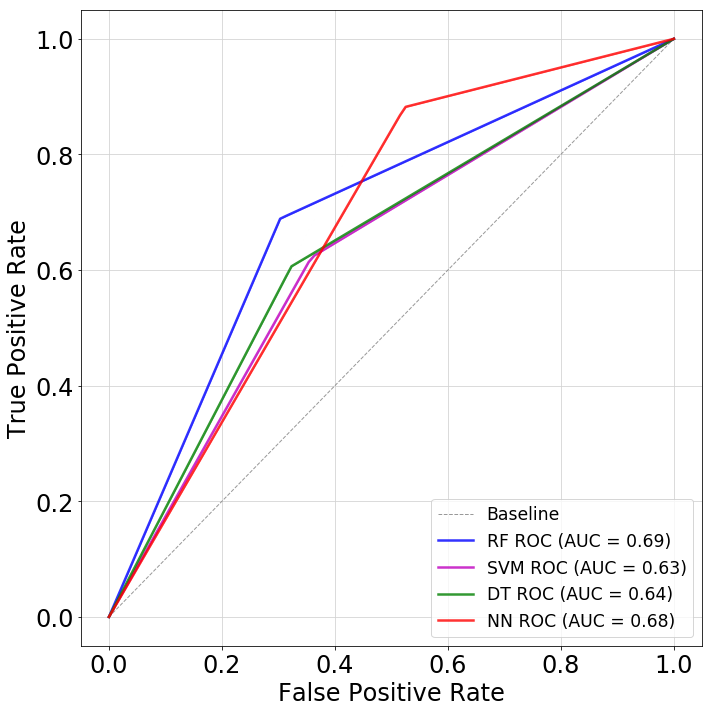

In [39]:
# PLOT THE BASELINE
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',
         label='Baseline', alpha=.8)

mean_cRF_tpr = np.mean(cRF_tprs, axis=0)
mean_cRF_tpr[-1] = 1.0
mean_cRF_auc = auc(mean_fpr, mean_cRF_tpr)
print("Mean AUC {}".format(mean_cRF_auc))
std_cRF_auc = np.std(cRF_aucs)

mean_cSVM_tpr = np.mean(cSVM_tprs, axis=0)
mean_cSVM_tpr[-1] = 1.0
mean_cSVM_auc = auc(mean_fpr, mean_cSVM_tpr)
print("Mean AUC {}".format(mean_cSVM_auc))
std_cSVM_auc = np.std(cSVM_aucs)

mean_cDT_tpr = np.mean(cDT_tprs, axis=0)
mean_cDT_tpr[-1] = 1.0
mean_cDT_auc = auc(mean_fpr, mean_cDT_tpr)
print("Mean AUC {}".format(mean_cDT_auc))
std_cDT_auc = np.std(cDT_aucs)

mean_cSNN_tpr = np.mean(cSNN_tprs, axis=0)
mean_cSNN_tpr[-1] = 1.0
mean_cSNN_auc = auc(mean_fpr, mean_cSNN_tpr)
print("Mean AUC {}".format(mean_cSNN_auc))
std_cSNN_auc = np.std(cSNN_aucs)

# PLOT the mean
plt.plot(mean_fpr, mean_cRF_tpr, color='b',
         label=r'RF ROC (AUC = %0.2f)' % (mean_cRF_auc),
         lw=2.5, alpha=.8)

std_cRF_tpr = np.std(cRF_tprs, axis=0)
cRF_tprs_upper = np.minimum(mean_cRF_tpr + std_cRF_tpr, 1)
cRF_tprs_lower = np.maximum(mean_cRF_tpr - std_cRF_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cRF_tprs_lower, cRF_tprs_upper, color='b', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cSVM_tpr, color='m',
         label=r'SVM ROC (AUC = %0.2f)' % (mean_cSVM_auc),
         lw=2.5, alpha=.8)

std_cSVM_tpr = np.std(cSVM_tprs, axis=0)
cSVM_tprs_upper = np.minimum(mean_cSVM_tpr + std_cSVM_tpr, 1)
cSVM_tprs_lower = np.maximum(mean_cSVM_tpr - std_cSVM_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cSVM_tprs_lower, cSVM_tprs_upper, color='m', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cDT_tpr, color='g',
         label=r'DT ROC (AUC = %0.2f)' % (mean_cDT_auc),
         lw=2.5, alpha=.8)

std_cDT_tpr = np.std(cDT_tprs, axis=0)
cDT_tprs_upper = np.minimum(mean_cDT_tpr + std_cDT_tpr, 1)
cDT_tprs_lower = np.maximum(mean_cDT_tpr - std_cDT_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cDT_tprs_lower, cDT_tprs_upper, color='g', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cSNN_tpr, color='r',
         label=r'NN ROC (AUC = %0.2f)' % (mean_cSNN_auc),
         lw=2.5, alpha=.8)

std_cSNN_tpr = np.std(cSNN_tprs, axis=0)
cSNN_tprs_upper = np.minimum(mean_cSNN_tpr + std_cSNN_tpr, 1)
cSNN_tprs_lower = np.maximum(mean_cSNN_tpr - std_cSNN_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cSNN_tprs_lower, cSNN_tprs_upper, color='r', alpha=.2)#, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('svPPA')
plt.legend(loc="lower right")
plt.grid(color="lightgray")
save_fig("fig",2_1)
plt.show()